In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import time
import pickle

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl    
mpl.rc('font',family='serif')

import seaborn as sns

import xgboost as xgb 
# from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, average_precision_score, recall_score, precision_recall_curve, roc_auc_score, roc_curve, precision_score, accuracy_score
from sklearn.utils.fixes import signature
from imblearn.under_sampling import RandomUnderSampler  

/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda

In [2]:
pkl_file = open('new_test_df.pkl', 'rb')

df_test = pickle.load(pkl_file)

pkl_file.close()

pkl_file = open('new_train_df.pkl', 'rb')

df_train = pickle.load(pkl_file)

pkl_file.close()



# Grid Search

In [3]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import GPy
import GPyOpt

from GPyOpt.methods import BayesianOptimization
from bayes_opt import BayesianOptimization as BOpt

/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
def get_train(df_train,df_test):
    X_labels = ['dce_mu','cm_mu','dce_slope','cm_slope','dce_acc','cm_acc','cm_mass','dce_mass']
    y_label = ['binary_best'] # Sloppy binarization

    df_test['binary_best'] = (df_test['best']>0)+0
    df_train['binary_best']  = (df_train['best']>0)+0
    
#     df_train = df_train.sample(1000).copy() # subset..

    
    X_train = df_train[X_labels]
    y_train = np.array(df_train[y_label]).ravel()
    
    return(X_train, y_train)

In [5]:
X_train, y_train = get_train(df_train,df_test) # year does not metter

In [6]:
xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=42)
baseline = cross_val_score(xg_cl, X_train, y_train, scoring = 'average_precision', cv=8, n_jobs=-1,  verbose=1).mean()

print(baseline)

[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   13.8s remaining:   41.3s


0.8298499622857212


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   15.2s finished


In [7]:
param_dist = {'eta': uniform(0,1),
             'gamma': uniform(0,10),
             'max_depth': range(1,50),
             'n_estimators':range(1,200), # 100
             'min_child_weight': range(1,10),
             'subsample' : uniform(0,1),
             'colsample_bytree': uniform(0,1)}

rs = RandomizedSearchCV(xg_cl, param_distributions=param_dist, scoring = 'average_precision', n_iter=60, n_jobs=-1, cv=8, verbose=1, random_state=42)
rs.fit(X_train, y_train)

print(rs.best_score_)

Fitting 8 folds for each of 60 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 130.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 331.7min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 374.6min finished


0.8869863172188491


In [8]:
bds = [{'name': 'eta', 'type': 'continuous', 'domain': (0, 1)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0, 10)},
        {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 50)},
        {'name': 'n_estimators', 'type': 'discrete', 'domain': (1, 200)},
        {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 10)},
        {'name': 'subsample', 'type' : 'continuous', 'domain': (0,1)},
        {'name': 'colsample_bytree', 'type' : 'continuous', 'domain' : (0,1) }]

# Optimization objective
def cv_score(parameters):
    parameters = parameters[0]
    score = cross_val_score(
        xgb.XGBClassifier(objective='binary:logistic', seed=42,
                          eta=parameters[0],
                          gamma=int(parameters[1]),
                          max_depth=int(parameters[2]),
                          n_estimators=int(parameters[3]),
                          min_child_weight = parameters[4],
                          subsample = parameters[5],
                          colsample_bytree = parameters[6]),
        X_train, y_train, scoring='average_precision', cv=8, n_jobs=-1).mean()
    score = np.array(score)
    return score

optimizer = BayesianOptimization(f=cv_score, 
                                 domain=bds,
                                 model_type='GP_MCMC',
                                 acquisition_type ='EI_MCMC',
                                 acquisition_jitter = 0.05,
                                 exact_feval=True, 
                                 maximize=True,
                                 verbosity = True,
                                 verbosity_model = True,
                                 num_cores = 8)

# Only 20 iterations because we have 5 initial random points
optimizer.run_optimization(max_iter=55)

#print(-optimizer.fx_opt) # men skal - væk?
print(-optimizer.fx_opt) 

reconstraining parameters GP_regression.rbf
reconstraining parameters GP_regression.Gaussian_noise.variance


0.8825404114446704


In [9]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
# from skopt import gp_maximize


from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score

cls = XGBClassifier()

space = [
    Integer(1, 50, name='max_depth'),
#     Real(10**-5, 10**0, 'log-uniform', name='learning_rate'),
    Real(0.1, 1, name='learning_rate'),
    Integer(5, 200, name='n_estimators'),
    Real(0.1, 10, name='gamma'),
    Integer(1, 5, name='min_child_weight'),
    Real(0.1, 1, name='subsample'),
    Real(0.1, 1, name='colsample_bytree')
]

@use_named_args(space)
def objective(**params):
    cls.set_params(**params)

    return -np.mean(cross_val_score(cls, X_train, y_train, cv=8, n_jobs=-1,
                                    scoring="average_precision"))

res_gp = gp_minimize(objective, space, n_calls=60, random_state=0)

"Best score=%.4f" % -res_gp.fun

'Best score=0.8892'

Baseline AP = 0.83
Random search AP = 0.89
Bayesian optimization AP = 0.88
Bayesian optimization 2 AP = 0.89


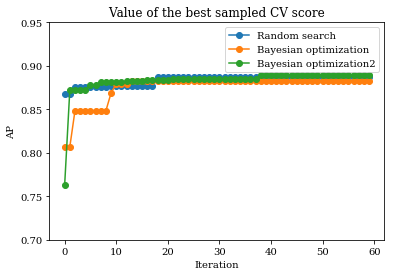

In [10]:
y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()
y_bo2 = np.maximum.accumulate(-res_gp.func_vals)

print(f'Baseline AP = {baseline:.2f}')
print(f'Random search AP = {y_rs[-1]:.2f}')
print(f'Bayesian optimization AP = {y_bo[-1]:.2f}')
print(f'Bayesian optimization 2 AP = {-res_gp.fun:.2f}')


plt.plot(y_rs, 'o-', label='Random search')
plt.plot(y_bo, 'o-', label='Bayesian optimization')
plt.plot(y_bo2, 'o-', label='Bayesian optimization2')

plt.xlabel('Iteration')
plt.ylabel('AP')
plt.ylim(0.70, 0.95)
plt.title('Value of the best sampled CV score')
plt.legend()

plt.show()

In [11]:
print(f'eta:{optimizer.x_opt[0]}\
        \ngamma: {optimizer.x_opt[1]}\
        \nmax_depth: {optimizer.x_opt[2]}\
        \nn_estimators: {optimizer.x_opt[3]}\
        \nmin_child_weight: {optimizer.x_opt[4]}\
        \nsubsample: {optimizer.x_opt[5]}\
        \ncolsample_bytree: {optimizer.x_opt[6]}')

eta:1.0        
gamma: 10.0        
max_depth: 50.0        
n_estimators: 200.0        
min_child_weight: 1.0        
subsample: 1.0        
colsample_bytree: 1.0


In [12]:
rs.best_params_

{'colsample_bytree': 0.6334037565104235,
 'eta': 0.8714605901877177,
 'gamma': 8.036720768991145,
 'max_depth': 44,
 'min_child_weight': 4,
 'n_estimators': 30,
 'subsample': 0.8832802589188683}

In [13]:
print(f'max_depth: {res_gp.x[0]}\
        \neta:{res_gp.x[1]}\
        \nn_estimators: {res_gp.x[2]}\
        \ngamma: {res_gp.x[3]}\
        \nmin_child_weight: {res_gp.x[4]}\
        \nsubsample: {res_gp.x[5]}\
        \ncolsample_bytree: {res_gp.x[6]}')

max_depth: 47        
eta:0.1        
n_estimators: 27        
gamma: 10.0        
min_child_weight: 1        
subsample: 0.8065904335629459        
colsample_bytree: 1.0


# Pickle

In [23]:
file_name = "random_GS.pkl"
output = open(file_name, 'wb') 
pickle.dump(rs.best_params_, output)
output.close()

file_name = "bayesian_GS.pkl"
output = open(file_name, 'wb') 
pickle.dump(optimizer.x_opt, output)
output.close()

file_name = "bayesian_GS2.pkl"
output = open(file_name, 'wb') 
pickle.dump(res_gp.x, output)
output.close()

file_name = "bayesian_GS2_meta.pkl"
output = open(file_name, 'wb') 
pickle.dump(res_gp, output)
output.close()

# Pickle test

In [24]:
pkl_file = open('random_GS.pkl', 'rb')
random_GS_test = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('bayesian_GS.pkl', 'rb')
bayesian_GS_test = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('bayesian_GS2.pkl', 'rb')
bayesian_GS2_test = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('bayesian_GS2_meta.pkl', 'rb')
bayesian_GS2_meta_test = pickle.load(pkl_file)
pkl_file.close()

In [20]:
print(f'eta:{bayesian_GS_test[0]}\
        \ngamma: {bayesian_GS_test[1]}\
        \nmax_depth: {bayesian_GS_test[2]}\
        \nn_estimators: {bayesian_GS_test[3]}\
        \nmin_child_weight: {bayesian_GS_test[4]}\
        \nsubsample: {bayesian_GS_test[5]}\
        \ncolsample_bytree: {bayesian_GS_test[6]}')

eta:1.0        
gamma: 10.0        
max_depth: 50.0        
n_estimators: 200.0        
min_child_weight: 1.0        
subsample: 1.0        
colsample_bytree: 1.0


In [21]:
random_GS_test

{'colsample_bytree': 0.6334037565104235,
 'eta': 0.8714605901877177,
 'gamma': 8.036720768991145,
 'max_depth': 44,
 'min_child_weight': 4,
 'n_estimators': 30,
 'subsample': 0.8832802589188683}

In [22]:
print(f'max_depth: {bayesian_GS2_test[0]}\
        \neta:{bayesian_GS2_test[1]}\
        \nn_estimators: {bayesian_GS2_test[2]}\
        \ngamma: {bayesian_GS2_test[3]}\
        \nmin_child_weight: {bayesian_GS2_test[4]}\
        \nsubsample: {bayesian_GS2_test[5]}\
        \ncolsample_bytree: {bayesian_GS2_test[6]}')

max_depth: 47        
eta:0.1        
n_estimators: 27        
gamma: 10.0        
min_child_weight: 1        
subsample: 0.8065904335629459        
colsample_bytree: 1.0


In [25]:
bayesian_GS2_meta_test.func_vals

array([-0.76329962, -0.87238762, -0.85370448, -0.82980955, -0.85258377,
       -0.87780682, -0.81817274, -0.88098186, -0.84051879, -0.8103388 ,
       -0.73497862, -0.83270512, -0.88223341, -0.72368658, -0.88013474,
       -0.87766551, -0.88398087, -0.88022297, -0.68298043, -0.84497329,
       -0.83105156, -0.88461837, -0.88127757, -0.8314421 , -0.79492094,
       -0.88075053, -0.84684407, -0.85462778, -0.64879138, -0.84503875,
       -0.79557269, -0.88221413, -0.88460698, -0.8333357 , -0.87040105,
       -0.81156209, -0.84709777, -0.88027144, -0.88919976, -0.88698732,
       -0.88141224, -0.87965672, -0.87166499, -0.85551302, -0.86897761,
       -0.88197007, -0.86782558, -0.87163332, -0.83356984, -0.88667741,
       -0.85735987, -0.83841221, -0.8546792 , -0.82879805, -0.87921731,
       -0.87416146, -0.87746185, -0.8663072 , -0.62475821, -0.87210231])